In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import argparse
import time
import torch
import torch.nn as nn
import torch.nn.parallel

import torch.utils.data
import matplotlib.pyplot as plt
import warnings 

from torchvision import datasets, transforms
from model.model_architectures import construct_model
from utils.reconstructed import convert_relu_to_sigmoid
from utils.config import config
from model.generator import trainer
warnings.filterwarnings("ignore")


In [2]:
dataset = datasets.CIFAR10(
        root='../Datasets/CIFAR10/', download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))

In [3]:
# Initialize the manual seed and model
arch = 'ResNet18'
model, _ = construct_model(arch, seed=42, num_classes=10, num_channels=3)
model = model.to(config['device'])
convert_relu_to_sigmoid(model)

Model initialized with random key 42.


In [4]:
size_batch = 16
config["nz"] = 128
config['total_img'] = size_batch
config['b_size'] = size_batch
config['num_epochs'] = 2000
config['rep_freq'] = config['num_epochs']/100

attack =  {'method':'CI-Net','lr':0.001}
config['lr']=attack['lr']
trainer = trainer(config,attack,model,dataset)        

reconstructed_image,avg_score = trainer.attack_training()

-----------------ATTACK BEGIN----------------
Configuration Parameters : {'workers': 2, 'b_size': 16, 'num_epochs': 2000, 'lr': 0.001, 'tv_value': 0.0, 'beta1': 0.5, 'ngpu': 1, 'device': device(type='cuda', index=0), 'dst': 'cifar10', 'lr_decay': False, 'signed': True, 'saved_location': './Results', 'classes': 10, 'nc': 3, 'nz': 128, 'ngf': 64, 'noise_setting': 'once', 'rep_freq': 20.0, 'total_img': 16, 'data_shape': torch.Size([16, 3, 32, 32])}
The channel number is 32


Processing:   0%|          | 0/2000 [00:00<?, ?it/s]

-----------------ATTACK END----------------
Total time for calculating IQA: 0.6096522172292074
Hightest IQA at other index 99
Hightest IQA at other index 99
-----------------IMAGE ASSESSMENT END----------------


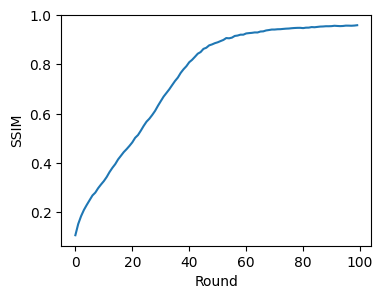

In [5]:
plt.figure(figsize=(4, 3))
plt.plot(avg_score["0"]['CI-Net']['ssim']['score'])
plt.ylabel("SSIM")
plt.xlabel("Round")
plt.show()

## Results Visualization

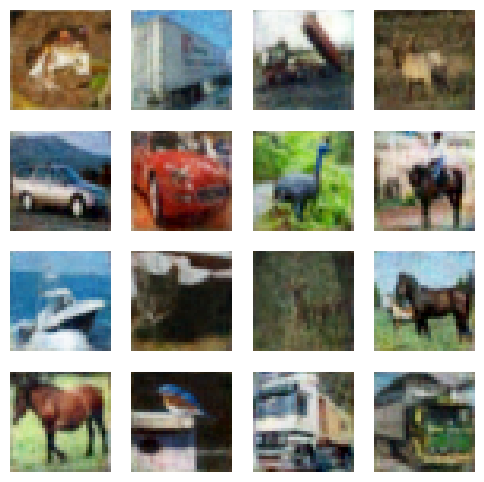

In [6]:
# Plot obtained images
import numpy as np
horizontal = int(np.sqrt(size_batch))
vertical = int(np.sqrt(size_batch))
fig, axes = plt.subplots(horizontal, vertical, figsize=(6,6))
for i in range(horizontal):
    for j in range(vertical):
        axes[i,j].imshow(torch.clamp(reconstructed_image["0"]["image"]['CI-Net']['ssim']["timeline"][0][-1][horizontal*i+j],min = 0 ,max =1)\
                         .detach().cpu().permute(1,2,0))
        axes[i,j].axis('off')
plt.show()